In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from pathlib import Path
from treelib import Tree
from pycocotools.coco import COCO

#### Data structure

In [2]:
def get_unique_name(tree, desired_name, suffix=0):
    new_name = desired_name + "_" + str(suffix)
    if tree.contains(new_name):
        return get_unique_name(tree, desired_name, suffix + 1)
    return new_name

def build_tree(path, parent_node):
    node_name = os.path.basename(path)
    unique_node_name = get_unique_name(tree, node_name)
    tree.create_node(node_name, unique_node_name, parent_node)
    
    counter = 0
    for item in os.listdir(path):
        item_path = os.path.join(path, item)
        if os.path.isdir(item_path):
            build_tree(item_path, unique_node_name)
        elif counter < 3:
            unique_item_name = get_unique_name(tree, item)
            tree.create_node(item, unique_item_name, unique_node_name)
            counter += 1

In [3]:
main_path = Path("../data/")
tree = Tree()
tree.create_node(main_path, main_path)

build_tree(main_path, main_path)
print(tree)

..\data
└── data
    ├── training_data
    │   ├── quadrant
    │   │   ├── train_quadrant.json
    │   │   └── xrays
    │   │       ├── train_0.png
    │   │       ├── train_1.png
    │   │       └── train_10.png
    │   ├── quadrant-enumeration-disease
    │   │   ├── train_quadrant_enumeration_disease.json
    │   │   └── xrays
    │   │       ├── train_0.png
    │   │       ├── train_1.png
    │   │       └── train_10.png
    │   ├── quadrant_enumeration
    │   │   ├── train_quadrant_enumeration.json
    │   │   └── xrays
    │   │       ├── train_0.png
    │   │       ├── train_1.png
    │   │       └── train_10.png
    │   └── unlabelled
    │       └── xrays
    │           ├── train_0.png
    │           ├── train_1.png
    │           └── train_10.png
    └── validation_data
        └── quadrant_enumeration_disease
            └── xrays
                ├── val_0.png
                ├── val_1.png
                └── val_10.png



#### Exploratory Data Analysis

In [4]:
json_file_paths = list(main_path.glob("*/*/*.json"))

for file_path in json_file_paths:
    file_name = str(file_path).split("\\")[-1]

    with open(file_path, "r") as file:
        data = json.load(file)

    print(f"File path: {file_path}\nFile: {file_name}\nImages: {len(data['images'])}\n")

File path: ..\data\training_data\quadrant\train_quadrant.json
File: train_quadrant.json
Images: 693

File path: ..\data\training_data\quadrant-enumeration-disease\train_quadrant_enumeration_disease.json
File: train_quadrant_enumeration_disease.json
Images: 705

File path: ..\data\training_data\quadrant_enumeration\train_quadrant_enumeration.json
File: train_quadrant_enumeration.json
Images: 634



The received data has been divided into a training dataset (training_data) and a validation dataset (validation_data), which contains only 50 images. The training dataset is hierarchically organized into three types of data;
- 693 X-rays labeled for quadrant detection and quadrant classes only,
- 634 X-rays labeled for tooth detection with quadrant and tooth enumeration classes,
- 705 X-rays fully labeled for abnormal tooth detection with quadrant, tooth enumeration, and diagnosis classes.

The diagnosis class includes four specific categories: caries, deep caries, periapical lesions, and impacted teeth. An additional 1571 unlabeled X-rays are provided for pre-training.


After a manual review of the images, it was determined that they are of high quality and similar in nature. No damaged images or artifacts were found, and all files are readable.

In [5]:
folder_path = main_path / "training_data/quadrant_enumeration/"
file_path = folder_path / "train_quadrant_enumeration.json"

with open(file_path, "r") as file:
    data = json.load(file)

Special attention was given to the set of images related to tooth detection with quadrant and tooth enumeration classes. This set contains two groups of annotation categories: the first group (categories_1) is for detecting quadrants of the oral cavity, and the second group (categories_2) is for detecting individual tooth numbers. The analysis focused on the latter group of categories.

Mean: Ratio: 2.14, Width: 2796, Height: 1308
Standard Deviation: Ratio 0.1, Width: 255, Height: 114


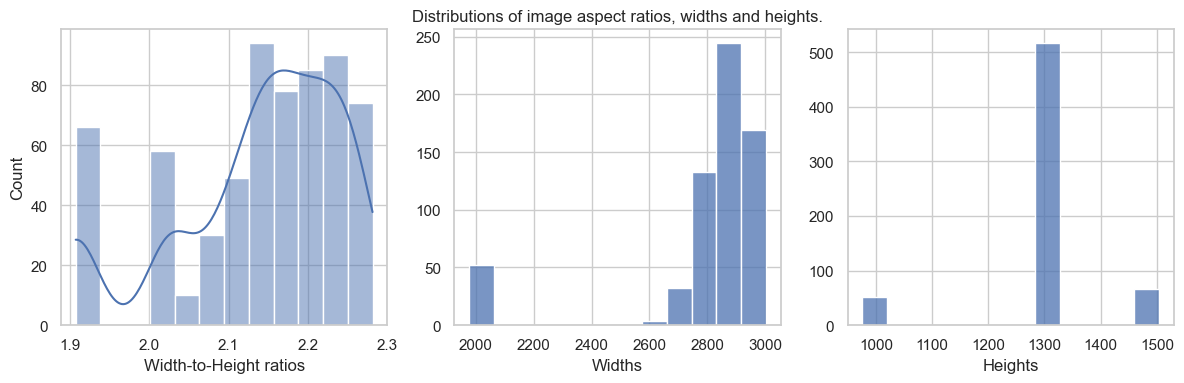

In [6]:
heights = [d["height"] for d in data["images"]]
widths = [d["width"] for d in data["images"]]
ratios = [d["width"] / d["height"] for d in data["images"]]

print(f"Mean: Ratio: {round(np.mean(ratios), 2)}, Width: {round(np.mean(widths))}, Height: {round(np.mean(heights))}")
print(f"Standard Deviation: Ratio {round(np.std(ratios), 2)}, Width: {round(np.std(widths))}, Height: {round(np.std(heights))}")

sns.set(style="whitegrid")
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

sns.histplot(ratios, bins=12, kde=True, ax=axs[0])
axs[0].set_xlabel("Width-to-Height ratios") 

sns.histplot(heights, bins=12, ax=axs[2])
axs[2].set_xlabel("Heights")
axs[2].set_ylabel("")

sns.histplot(widths, bins=12, ax=axs[1])
axs[1].set_title("Distributions of image aspect ratios, widths and heights.")
axs[1].set_xlabel("Widths")
axs[1].set_ylabel("") 

plt.tight_layout()
plt.show()

On average, the width and height of the analyzed images were approximately 2800 and 1300 pixels, resulting in an aspect ratio close to 2.1. The image proportions showed low variability, with a standard deviation of nearly 0.1, suggesting that the images are mainly horizontal and have similar proportions.

In [7]:
heights = []

for dictionary in data["images"]:
    if dictionary["width"] < 2400:
        heights.append(dictionary["height"])

height_counter = np.unique(heights, return_counts=True)
print(f"Height: {height_counter[0].item()} for {height_counter[1].item()} images.")

Height: 976 for 52 images.


It was observed that images with slightly smaller width (around 2000 pixels) also had slightly smaller height (around 1000 pixels), but this did not negatively affect the width-height ratios.

Mean: 3680386, Standard Deviation 556605


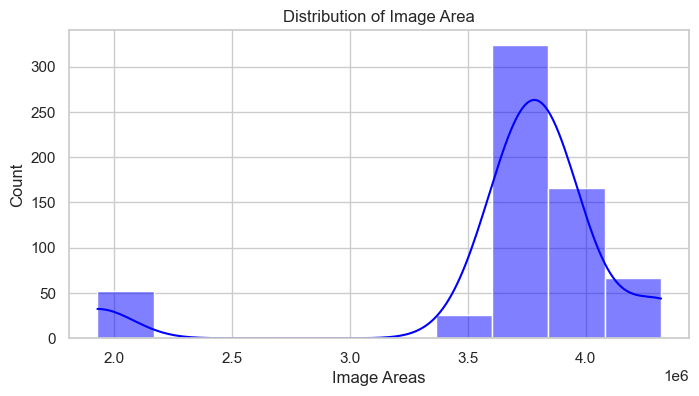

In [8]:
areas = [d["height"] * d["width"] for d in data["images"]]
print(f"Mean: {round(np.mean(areas))}, Standard Deviation {round(np.std(areas))}")

plt.figure(figsize=(8, 4))
sns.histplot(x=areas, bins=10, color="blue", kde=True, label="minimum")

plt.title("Distribution of Image Area")
plt.xlabel("Image Areas")
plt.show()

Mean: Ratio: 0.43, Width: 126, Height: 304
Standard Deviation: Ratio 0.23, Width: 57, Height: 61


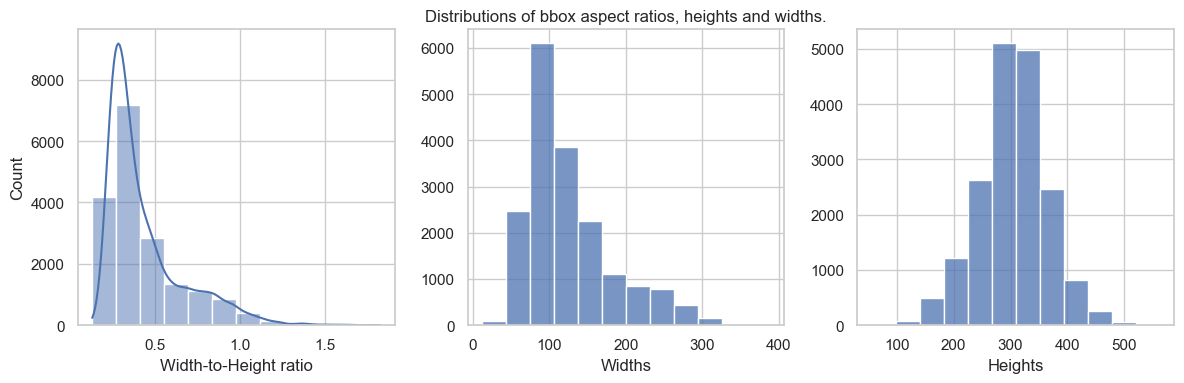

In [9]:
widths = [d["bbox"][2] for d in data["annotations"]]
heights = [d["bbox"][3] for d in data["annotations"]]
ratios = [d["bbox"][2] / d["bbox"][3] for d in data["annotations"]]

print(f"Mean: Ratio: {round(np.mean(ratios), 2)}, Width: {round(np.mean(widths))}, Height: {round(np.mean(heights))}")
print(f"Standard Deviation: Ratio {round(np.std(ratios), 2)}, Width: {round(np.std(widths))}, Height: {round(np.std(heights))}")

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(ratios, bins=12, kde=True, ax=axs[0])
axs[0].set_xlabel("Width-to-Height ratio") 

sns.histplot(widths, bins=12, ax=axs[1])
axs[1].set_title("Distributions of bbox aspect ratios, heights and widths.")
axs[1].set_xlabel("Widths")
axs[1].set_ylabel("") 

sns.histplot(heights, bins=12, ax=axs[2])
axs[2].set_xlabel("Heights")
axs[2].set_ylabel("")

plt.tight_layout()
plt.show()

The analysis of label bounding boxes revealed that the average width-to-height ratio is approximately 0.4, with a standard deviation close to 0.2. This indicates that most bounding boxes are vertical, although more horizontal cases do occur, which is understandable given the vertical orientation of most teeth.

Mean: 38276, Standard Deviation 18399


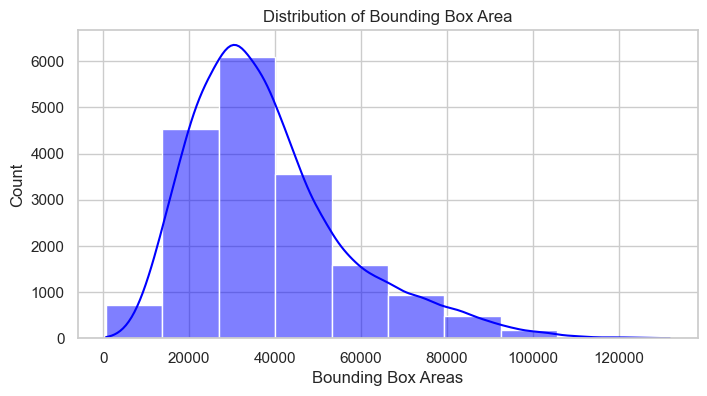

In [10]:
bbox_areas = [np.prod(d["bbox"][2:]) for d in data["annotations"]]

print(f"Mean: {round(np.mean(bbox_areas))}, Standard Deviation {round(np.std(bbox_areas))}")

plt.figure(figsize=(8, 4))
sns.histplot(x=bbox_areas, bins=10, color="blue", kde=True, label="minimum")

plt.title("Distribution of Bounding Box Area")
plt.xlabel("Bounding Box Areas")
plt.show()

In the context of image processing (e.g., resizing), it is essential to note that the average bounding box label area is approximately 100 times smaller than the average image area, resulting in a similarity scale of about 10.

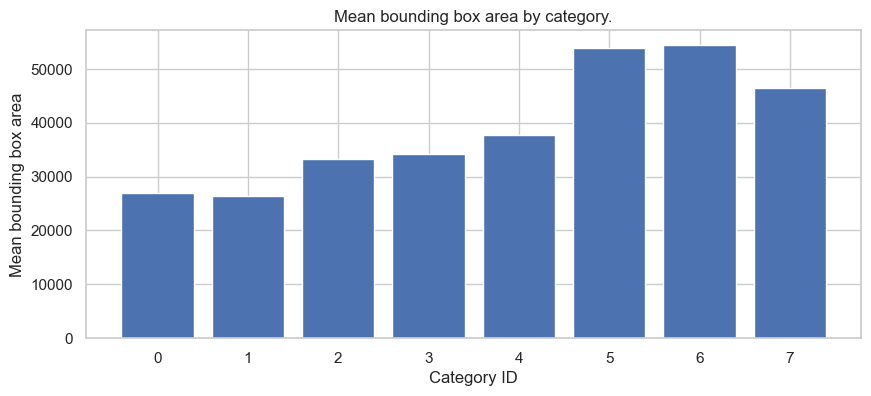

In [11]:
category_stats = {}

for dictionary in data["annotations"]:
    category_id = dictionary["category_id_2"]
    bbox_area = np.prod(dictionary["bbox"][2:])

    if category_id in category_stats:
        category_stats[category_id]["total_area"] += bbox_area
        category_stats[category_id]["count"] += 1
    else:
        category_stats[category_id] = {"total_area": bbox_area, "count": 1}

mean_areas = {}

for category_id, stats in category_stats.items():
    mean_area = stats["total_area"] / stats["count"]
    mean_areas[category_id] = mean_area

categories = list(mean_areas.keys())
mean_area_values = list(mean_areas.values())

plt.figure(figsize=(10, 4))
plt.bar(categories, mean_area_values)
plt.xlabel("Category ID")
plt.ylabel("Mean bounding box area")
plt.title("Mean bounding box area by category.")
plt.xticks(categories)
plt.show()

The average sizes of bounding box label areas for each category were also presented. A slight disproportion was observed, with categories 5, 6, and 7 (corresponding to molar teeth) having areas twice as large as categories 0 and 1 (corresponding to incisors). This discrepancy is due to both differences in tooth sizes and the more diagonal positioning of molar teeth.

In [12]:
iscrowd_counter = np.unique([d['iscrowd'] for d in data['annotations']], return_counts=True)
print(f"iscrowd: {iscrowd_counter[0]}, annotations: {iscrowd_counter[1]}")

iscrowd: [0], annotations: [18095]


Annotations only take the value zero for the 'iscrowd' key, which rules out the necessity of using two models for images with individual and group annotations.

In [13]:
segmentation_counter = np.unique([len(d["segmentation"]) for d in data["annotations"]], return_counts=True)
print(f"Number of segmentations: {segmentation_counter[0]}, annotations: {segmentation_counter[1]}")

Number of segmentations: [1], annotations: [18095]


The situation is similar concerning the number of segmentations in a single annotation, which never exceeds 1, indicating no overlap between objects visually. This may suggests the absence of extreme cases of curved teeth in the analyzed dataset.

Total minimum value: 361, Mean minimum value: 669
Total maximum value: 2612, Mean maximum value: 2138


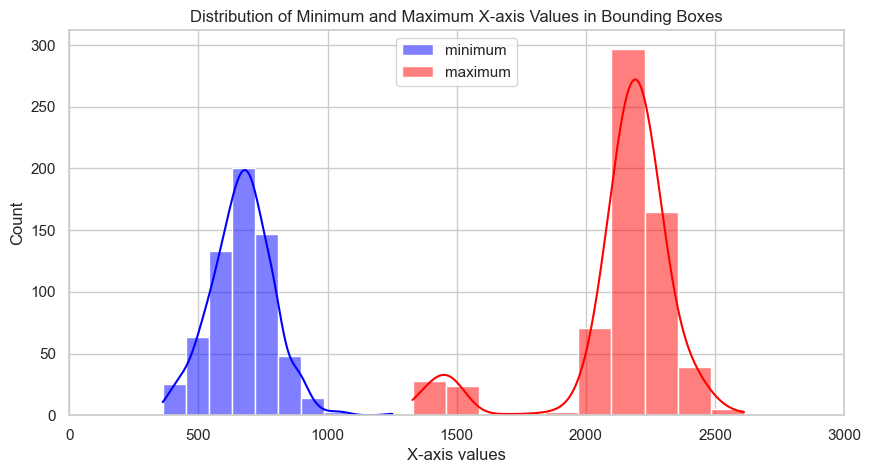

In [14]:
total_bbox = {}

for dictionary in data["annotations"]:
    image_id = dictionary["image_id"]
    x_min = dictionary["bbox"][0]
    x_max = x_min + dictionary["bbox"][2]

    if image_id not in total_bbox:
        total_bbox[image_id] = {"x_min": x_min, "x_max": x_max}
    else:
        if x_min < total_bbox[image_id]["x_min"]:
            total_bbox[image_id]["x_min"] = x_min
        if x_max > total_bbox[image_id]["x_max"]:
            total_bbox[image_id]["x_max"] = x_max

min_values, max_values = [], []

for image_id, bbox_data in total_bbox.items():
    min_values.append(bbox_data["x_min"])
    max_values.append(bbox_data["x_max"])

print(f"Total minimum value: {int(np.min(min_values))}, Mean minimum value: {int(np.mean(min_values))}")
print(f"Total maximum value: {int(np.max(max_values))}, Mean maximum value: {int(np.mean(max_values))}")

plt.figure(figsize=(10, 5))
sns.histplot(x=min_values, bins=10, color="blue", kde=True, label="minimum")
sns.histplot(x=max_values, bins=10, color="red", kde=True, label="maximum")


plt.title("Distribution of Minimum and Maximum X-axis Values in Bounding Boxes")
plt.xlabel("X-axis values")
plt.xlim(0, 3000)
plt.legend(loc="upper center")
plt.show()

An analysis of the distribution of minimum and maximum values on the X-axis for bounding boxes was also conducted. The results showed that the area of interest generally falls between 670 and 2140 pixels, with extreme values being 360 and 2610 pixels, respectively.

Total minimum value: 0.14, Mean minimum value: 0.24
Total maximum value: 0.91, Mean maximum value: 0.76


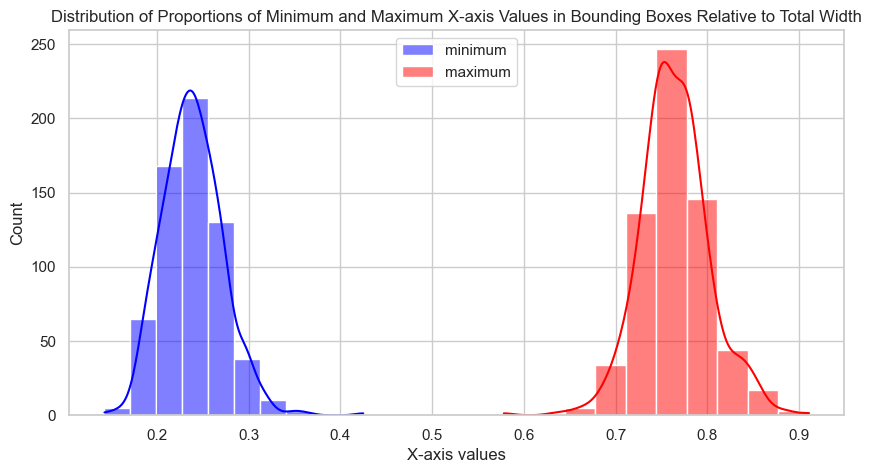

In [15]:
proportions = total_bbox
min_values, max_values = [], []

for dictionary in data["images"]:
    image_id = dictionary["id"]
    width = dictionary["width"]
    proportions[image_id]["x_min"] = total_bbox[image_id]["x_min"] / width
    proportions[image_id]["x_max"] = total_bbox[image_id]["x_max"] / width

for image_id, proportion_data in proportions.items():
    min_values.append(proportion_data["x_min"])
    max_values.append(proportion_data["x_max"])

print(f"Total minimum value: {np.round(np.min(min_values), 2)}, Mean minimum value: {np.round(np.mean(min_values), 2)}")
print(f"Total maximum value: {np.round(np.max(max_values), 2)}, Mean maximum value: {np.round(np.mean(max_values), 2)}")

plt.figure(figsize=(10, 5))
sns.histplot(x=min_values, bins=10, color="blue", kde=True, label="minimum")
sns.histplot(x=max_values, bins=10, color="red", kde=True, label="maximum")


plt.title("Distribution of Proportions of Minimum and Maximum X-axis Values in Bounding Boxes Relative to Total Width")
plt.xlabel("X-axis values")
plt.legend(loc="upper center")
plt.show()

#### Exploration using PyCOCO

In [16]:
print(f"Keys: {list(data.keys())}\nAnnotations keys: {list(data['annotations'][0].keys())}")

Keys: ['images', 'annotations', 'categories_1', 'categories_2']
Annotations keys: ['iscrowd', 'image_id', 'bbox', 'segmentation', 'id', 'area', 'category_id_1', 'category_id_2']


In [17]:
main_file_path = folder_path / "main_file.json"

data["categories"] = data.pop("categories_2")

for dictionary in data["annotations"]:
    dictionary["category_id"] = dictionary.pop("category_id_2")

with open(main_file_path, "w") as file:
        json.dump(data, file, indent=4)

with open(main_file_path, "r") as file:
        data = json.load(file)

print(f"Keys: {list(data.keys())}\nAnnotations keys: {list(data['annotations'][0].keys())}")

Keys: ['images', 'annotations', 'categories_1', 'categories']
Annotations keys: ['iscrowd', 'image_id', 'bbox', 'segmentation', 'id', 'area', 'category_id_1', 'category_id']


In [18]:
def explore_categories(coco):
    num_images = len(coco.getImgIds())
    print(f"\nNumber of images: {num_images}")
    cat_ids = coco.getCatIds()
    print(f"Number of unique categories: {len(cat_ids)}")
    print(f"Category IDs: {cat_ids}")

    cats = coco.loadCats(cat_ids)
    cat_names = [cat["name"] for cat in cats]
    print(f"Categories names: {cat_names}\n")

    query_data = []

    for query_id in cat_ids:
        query_annotation = coco.loadCats([query_id])[0]
        query_name = query_annotation["name"]
        query_supercategory = query_annotation["supercategory"]

        img_ids = coco.getImgIds(catIds=[query_id])
        print(f"Category ID: {query_id}, Category name: {query_name}, Supercategory: {query_supercategory}.")
        print(f"Number of images containing this category: {len(img_ids)} ({round(100 * len(img_ids)/num_images)}%)")

        query_data.append({"query_id": query_id, "query_name": query_name, "num_images": len(img_ids)})

    sns.set(style="whitegrid")
    ax = sns.barplot(x="query_name", y="num_images", data=pd.DataFrame(query_data))
    plt.xlabel("Category name")
    plt.ylabel("Number of images")
    plt.title(" Number of images for different categories")
    plt.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!

Number of images: 634
Number of unique categories: 8
Category IDs: [0, 1, 2, 3, 4, 5, 6, 7]
Categories names: ['1', '2', '3', '4', '5', '6', '7', '8']

Category ID: 0, Category name: 1, Supercategory: 1.
Number of images containing this category: 634 (100%)
Category ID: 1, Category name: 2, Supercategory: 2.
Number of images containing this category: 634 (100%)
Category ID: 2, Category name: 3, Supercategory: 3.
Number of images containing this category: 633 (100%)
Category ID: 3, Category name: 4, Supercategory: 4.
Number of images containing this category: 633 (100%)
Category ID: 4, Category name: 5, Supercategory: 5.
Number of images containing this category: 632 (100%)
Category ID: 5, Category name: 6, Supercategory: 6.
Number of images containing this category: 623 (98%)
Category ID: 6, Category name: 7, Supercategory: 7.
Number of images containing this category: 626 (99%)
Category ID: 7, Category

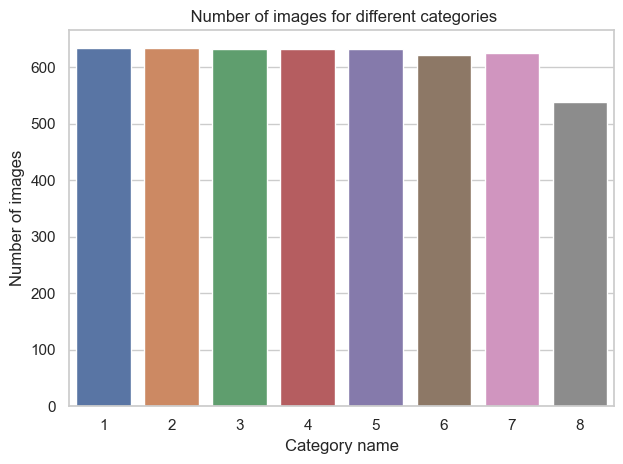

In [19]:
coco = COCO(main_file_path)

explore_categories(coco)

There are 8 label categories, corresponding to teeth from the center to the outer parts of the images. The majority of images have labels for all possible categories, indicating that almost every image has at least one representative from each category. The balance between these categories is maintained, with a slight deviation favoring category 8.

Mean: 28.5, Standard Deviation: 3.3


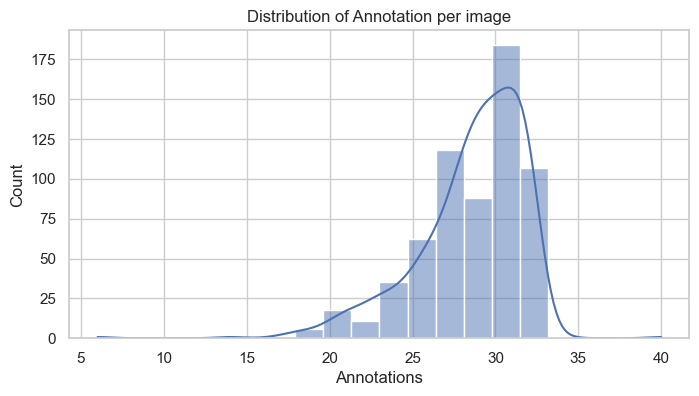

In [20]:
df = pd.DataFrame(data["annotations"])
image_id_counts = df["image_id"].value_counts().reset_index()
image_id_counts.columns = ["image_id", "no_annotations"]

print(f"Mean: {(image_id_counts['no_annotations'].mean().round(1))}, Standard Deviation: {(image_id_counts['no_annotations'].std().round(1))}")

plt.figure(figsize=(8, 4))
sns.histplot(x="no_annotations", bins=20, kde=True, data=image_id_counts)
plt.xlabel("Annotations")
plt.title("Distribution of Annotation per image")
plt.show()

It is noteworthy to consider the distribution of the number of annotations per image. The average number of annotations per image is 28.5, with a standard deviation of 3.3. This further confirms that the images have a large number of labels from various categories.

In [21]:
def plot_images(image_id, image_path):
    image = cv2.imread(image_path)
    ann_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(ann_ids)

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Panoramic dental X-rays")
    plt.axis("off")

    for annotation in annotations:
        bbox = annotation["bbox"]
        category_id = annotation["category_id"]
        category_info = coco.loadCats(category_id)[0]
        label = category_info["name"]

        x, y, w, h = [int(i) for i in bbox]
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title("Panoramic dental X-rays with annotations")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

Image ID: 349, File Name: train_94.png, Number of unique annotations: 30


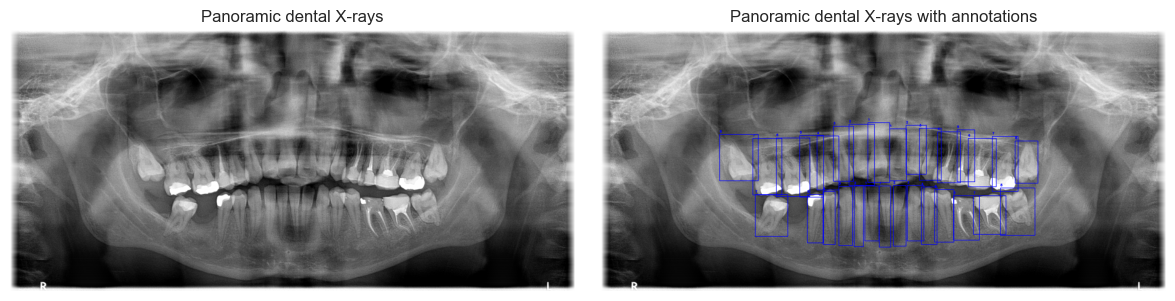

Image ID: 632, File Name: train_344.png, Number of unique annotations: 30


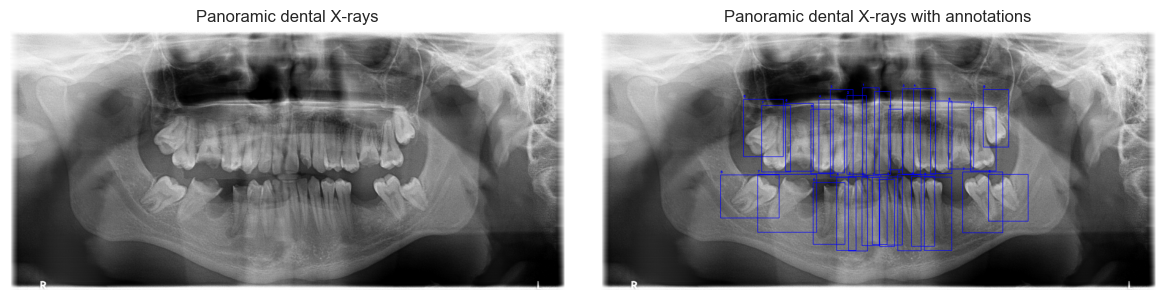

Image ID: 346, File Name: train_369.png, Number of unique annotations: 31


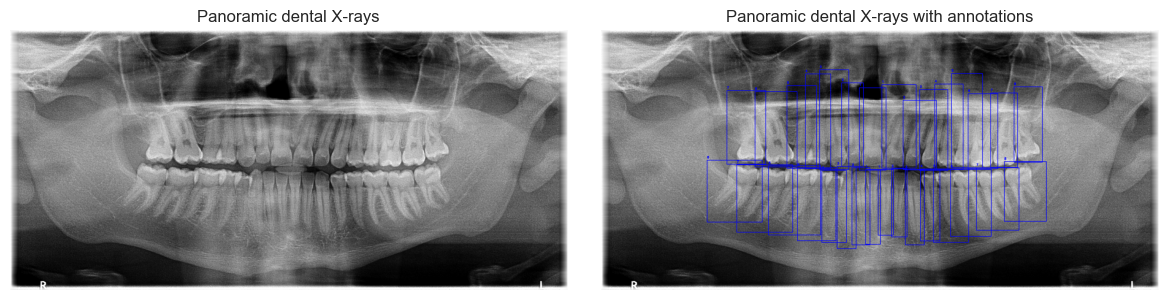

Image ID: 376, File Name: train_469.png, Number of unique annotations: 32


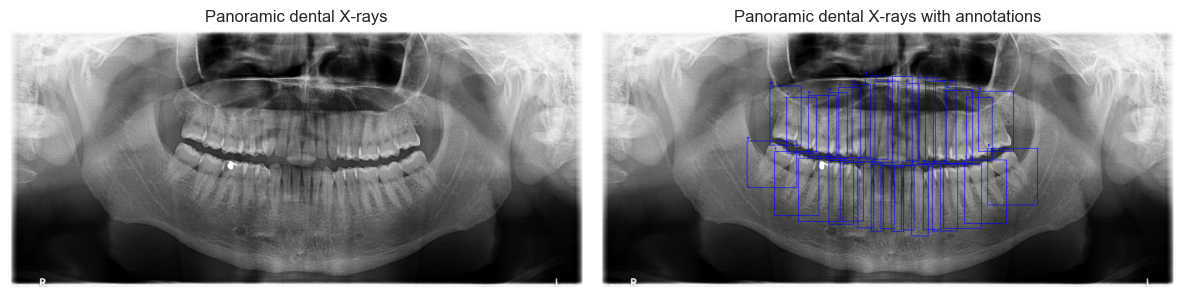

In [22]:
images_path = folder_path / "xrays"

total_images = len(coco.getImgIds())
random_image_ids = np.random.randint(1, total_images + 1, 4)

for image_id in random_image_ids:
    image_info = coco.loadImgs(int(image_id))[0]
    image_file_name = image_info["file_name"]
    image_path = str(images_path / image_file_name)

    ann_ids = coco.getAnnIds(imgIds=image_id, iscrowd=None)
    anns = coco.loadAnns(ann_ids)
    print(f"Image ID: {image_id}, File Name: {image_file_name}, Number of unique annotations: {len(anns)}")
    
    plot_images(image_id, image_path)

Sample X-ray images were presented both without and with annotations. After a thorough review of all the images, it was noticed that some are inaccurately labeled. Therefore, it is suggested to re-label these images or remove them from the training and validation sets.

#### Future Work Suggestions

In the context of the second task, considering all observations and insights from the conducted analysis, I propose the following actions:

- correct or remove images with incorrect labels from both the training and validation datasets.

- Focus on models for which the image input size is not heavily restricted, such as Faster R-CNN or RT-DERT. When considering significant resizing, bounding boxes may become too small, negatively impacting their detectability.

- Resize images to a predetermined width while maintaining proportions. The suggested width is 1250 pixels, which should not significantly affect recognizability.

- Crop images along the x-axis by a fixed percentage, for example, about 10% from each side. This will help improve image proportions without disturbing objects of interest, such as teeth. The resulting images will have a width of 1024 pixels, which is suitable for the RT-DERT model.

- Pad images to the desired model size. You can apply standard black padding or consider reflection padding, but this will require a thorough review of the images. However, keep in mind that there is a risk of introducing false negatives, especially in object detection problems.

- Limit further augmentation to:

     - Horizontal and vertical flips.

     - Rotations by angles of 90, 180, and 270 degrees to avoid affecting bounding boxes.

     - Random adjustments in brightness and contrast (Random Brightness Contrast).

     - Applying Cutout to remove portions of the image.
      